[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://bit.ly/open-data-04-coffee-store-input)

## 소상공인시장진흥공단 상가업소정보로 스타벅스, 이디야 위치 분석하기

* 이디야는 스타벅스 근처에 입점한다는 설이 있습니다. 과연 이디야와 스타벅스의 매장입지는 얼마나 차이가 날까요? 관련 기사를 읽고 구별로 이디야와 스타벅스의 매장을 기사와 유사하게 분석하고 시각화 해보면서 Python, Pandas, Numpy, Seaborn, Matplotlib, folium 을 통해 다양한 방법으로 표현해 봅니다..

### 다루는 내용
* 공공데이터를 활용해 텍스트 데이터 정제하고 원하는 정보 찾아내기
* 문자열에서 원하는 텍스트 추출하기
* 문자열을 활용한 다양한 분석 방법과 위치 정보 사용하기
* folium을 통한 위경도 데이터 시각화 이해하기

### 실습
* 텍스트 데이터 정제하기 -  대소문자로 섞여있는 상호명을 소문자로 변경하고 상호명 추출하기
* 텍스트 데이터에서 원하는 정보 추출하기 - 브랜드명 컬럼을 만들고 구별 매장 수 분석하기
* folium을 통해 지도에 분석한 내용을 표현하기 - CircleMarker와 choropleth 그리기


### 데이터셋
* https://www.data.go.kr/dataset/15012005/fileData.do
* 구별로 매장수를 표현하기 위해 GeoJSON 파일 로드
    * 파일출처 : [southkorea/seoul-maps: Seoul administrative divisions in ESRI Shapefile, GeoJSON and TopoJSON formats.](https://github.com/southkorea/seoul-maps)
    * 이 링크에서도 다운로드가 가능합니다. https://drive.google.com/open?id=13j8-_XLdPe0pptsqu8-uyE-0Ym6V2jw5

### 관련기사
* [[비즈&빅데이터]스타벅스 '쏠림' vs 이디야 '분산'](http://news.bizwatch.co.kr/article/consumer/2018/01/19/0015)

## 필요한 라이브러리 불러오기

In [1]:
# 데이터 분석을 위해 pandas를, 수치계산을 위해 numpy를, 시각화를 위해 seaborn을 불러옵니다.

# pandas, numpy, seaborn을 불러옵니다.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 구버전의 주피터 노트북에서 그래프가 보이는 설정
%matplotlib inline

## 시각화를 위한 한글 폰트 설정하기

In [2]:
# 한글폰트 설정
import matplotlib.font_manager as fm

font_location = '/usr/share/fonts/TTF/NanumGothic.ttf'  
                    # ex - 'C:/asiahead4.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()

# plt.rc("font", family="Malgun Gothic")
# plt.rc("font", family="AppleGothic")
# plt.rc("font", family="NanumGothic")
plt.rc("font", family=font_name)
plt.rc("axes", unicode_minus=False)

In [3]:
# 폰트가 선명하게 보이도록 retina 설정
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

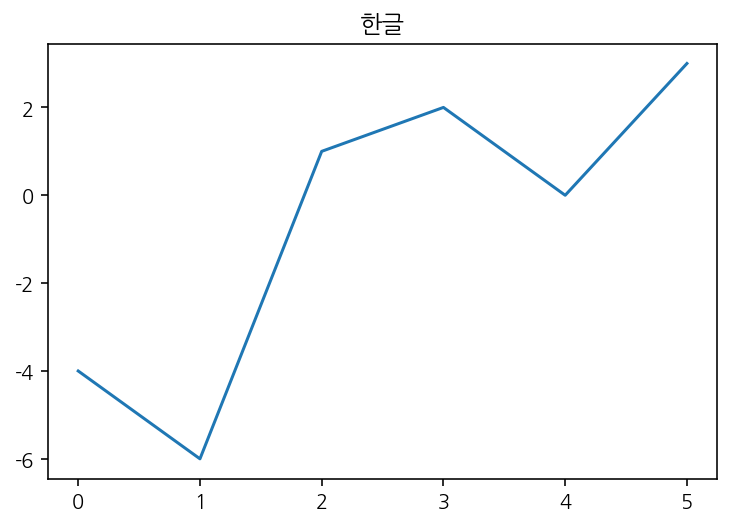

In [4]:
# 한글폰트와 마이너스 폰트 설정 확인
plt.title('한글')
plt.plot([-4,-6,1,2,0,3])

## Google Colab 을 위한 코드
### Colab 에서 실행을 위한 코드

* 아래의 코드는 google colaboratory 에서 실행을 위한 코드로 로컬 아나콘다에서는 주석처리합니다.
* google colaboratory 에서는 주석을 풀고 폰트 설정과 csv 파일을 불러옵니다.

In [5]:
# # 나눔고딕 설치
# !apt -qq -y install fonts-nanum > /dev/null

# import matplotlib.font_manager as fm

# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
# fm._rebuild()

# # 그래프에 retina display 적용
# %config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

### Colab 용 GoogleAuth 인증 
* 구글 드라이브에 있는 파일을 가져오기 위해 사용합니다.

In [6]:
# # 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # PyDrive client 인증
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [7]:
# # 공유 가능한 링크로 파일 가져오기
# url = 'https://drive.google.com/open?id=1e91PH_KRFxNXUsx8Hi-Q2vPiorCDsOP4'
# id = url.split('=')[1]
# print(id)
# downloaded = drive.CreateFile({'id':id}) 
# # data 폴더에 파일을 관리하며, 폴더가 없다면 만들어서 파일을 관리하도록 한다.
# %mkdir data
# downloaded.GetContentFile('data/상가업소정보_201912_01.csv')  

## 데이터 불러오기
* 공공데이터 포털 : https://www.data.go.kr/dataset/15012005/fileData.do
* 영상에 사용한 데이터셋 : http://bit.ly/open-data-set-folder (공공데이터포털에서 다운로드 받은 파일이 있습니다. 어떤 파일을 다운로드 받아야 될지 모르겠다면 여기에 있는 파일을 사용해 주세요.)

In [9]:
# 파일을 불러와 df 라는 변수에 담습니다.
# shape 를 통해 불러온 csv 파일의 크기를 확인합니다.
df = pd.read_csv('data/상가업소정보_201912_01.csv', sep="|")
df.shape

(573680, 39)

### 데이터 미리보기

In [10]:
df.head()

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,19905471,와라와라호프,NaN,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,...,1168010600106040000014378,대치상가,서울특별시 강남구 남부순환로 2933,135280,6280.0,NaN,1,NaN,127.061026,37.493922
1,19911397,커피빈코리아선릉로93길점,코리아선릉로93길점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,...,1168010100106960042022041,NaN,서울특별시 강남구 선릉로93길 6,135080,6149.0,NaN,1,NaN,127.047883,37.505675
2,19911801,프로포즈,NaN,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,...,1154510200101620001017748,NaN,서울특별시 금천구 가산로 34-6,153010,8545.0,NaN,1,NaN,126.899220,37.471711
3,19912201,싱싱커피&토스트,NaN,Q,음식,Q07,패스트푸드,Q07A10,토스트전문,I56192,...,2653010400105780000002037,산업용품유통상가,부산광역시 사상구 괘감로 37,617726,46977.0,NaN,1,26,128.980455,35.159774
4,19932756,가락사우나내스낵,NaN,F,생활서비스,F09,대중목욕탕/휴게,F09A02,사우나/증기탕/온천,S96121,...,1171010500102560005010490,NaN,서울특별시 송파구 가락로 71,138846,5690.0,NaN,1,NaN,127.104071,37.500249


### info 보기

In [11]:
# info 를 사용하면 데이터의 전체적인 정보를 볼 수 있습니다.
# 데이터의 사이즈, 타입, 메모리 사용량 등을 볼 수 있습니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573680 entries, 0 to 573679
Data columns (total 39 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   상가업소번호     573680 non-null  int64  
 1   상호명        573679 non-null  object 
 2   지점명        76674 non-null   object 
 3   상권업종대분류코드  573680 non-null  object 
 4   상권업종대분류명   573680 non-null  object 
 5   상권업종중분류코드  573680 non-null  object 
 6   상권업종중분류명   573680 non-null  object 
 7   상권업종소분류코드  573680 non-null  object 
 8   상권업종소분류명   573680 non-null  object 
 9   표준산업분류코드   539290 non-null  object 
 10  표준산업분류명    539290 non-null  object 
 11  시도코드       573680 non-null  int64  
 12  시도명        573680 non-null  object 
 13  시군구코드      573680 non-null  int64  
 14  시군구명       573680 non-null  object 
 15  행정동코드      573680 non-null  int64  
 16  행정동명       573680 non-null  object 
 17  법정동코드      573680 non-null  int64  
 18  법정동명       573680 non-null  object 
 19  지번코드       573680 non-n

### 결측치 보기

<AxesSubplot:>

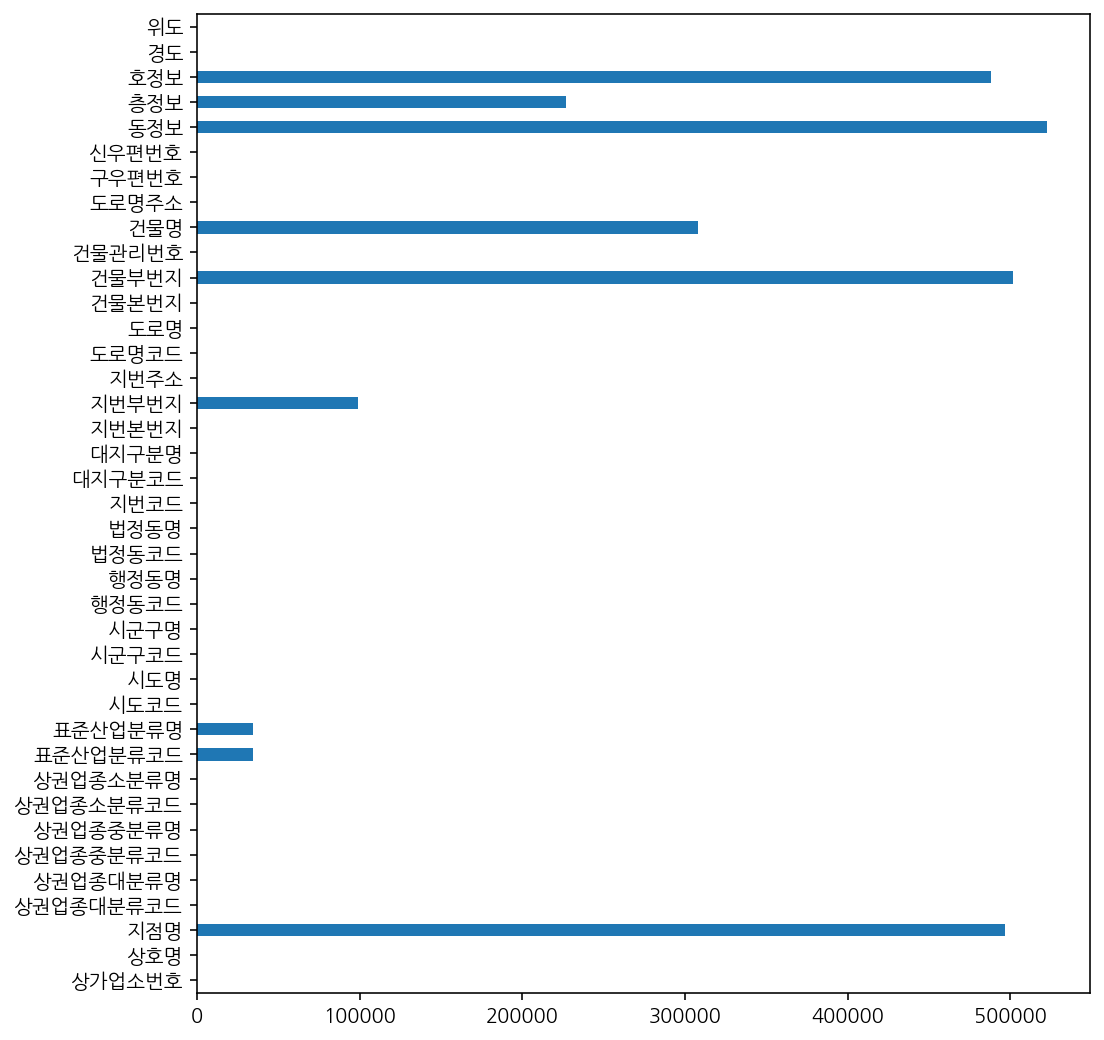

In [12]:
# isnull() 을 사용하면 데이터의 결측치를 볼 수 있습니다.
# 결측치는 True로 값이 있다면 False로 표시되는데 True 는 1과 같기 때문에 
# True 값을 sum()을 사용해서 더하게 되면 합계를 볼 수 있습니다.
df.isnull().sum().plot.barh(figsize=(8,9))

### 사용하지 않는 컬럼 제거하기

In [13]:
# drop을 하는 방법도 있지만 사용할 컬럼만 따로 모아서 보는 방법도 있습니다.
# 여기에서는 사용할 컬럼만 따로 모아서 사용합니다.
columns = ['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', 
           '시도명', '시군구명', '행정동명', '법정동명', '도로명주소', 
           '경도', '위도']

df = df[columns].copy()
df.shape

(573680, 11)

In [14]:
# 제거 후 메모리 사용량 보기
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573680 entries, 0 to 573679
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   상호명       573679 non-null  object 
 1   상권업종대분류명  573680 non-null  object 
 2   상권업종중분류명  573680 non-null  object 
 3   상권업종소분류명  573680 non-null  object 
 4   시도명       573680 non-null  object 
 5   시군구명      573680 non-null  object 
 6   행정동명      573680 non-null  object 
 7   법정동명      573680 non-null  object 
 8   도로명주소     573680 non-null  object 
 9   경도        573680 non-null  float64
 10  위도        573680 non-null  float64
dtypes: float64(2), object(9)
memory usage: 48.1+ MB


## 색인으로 서브셋 가져오기

### 서울만 따로 보기

In [19]:
# 시도명이 서울로 시작하는 데이터만 봅니다.
# 또, df_seoul 이라는 변수에 결과를 저장합니다.
# 새로운 변수에 데이터프레임을 할당할 때 copy()를 사용하는 것을 권장합니다.
# 시도명이 서울로 시작하는 데이터만 봅니다.
# 또, df_seoul 이라는 변수에 결과를 저장합니다.
# 새로운 변수에 데이터프레임을 할당할 때 copy()를 사용하는 것을 권장합니다.

df_seoul = df[df["시도명"] == "서울특별시"].copy()
df_seoul.shape

(407376, 11)

### 일부 텍스트가 들어가는 데이터만 가져오기
* 상호명에서 브랜드명을 추출합니다.
* 대소문자가 섞여 있을 수도 있기 때문에 대소문자를 변환해 줍니다.
* 오타를 방지하기 위해 스타벅스의 영문명은 STARBUCKS, 이디야는 EDIYA 입니다.

* https://pandas.pydata.org/docs/user_guide/text.html#testing-for-strings-that-match-or-contain-a-pattern

In [21]:
# 문자열의 소문자로 변경하는 메소드를 사용합니다.
# "상호명_소문자" 컬럼을 만듭니다.

df_seoul["상호명_소문자"] = df_seoul["상호명"].str.lower()

In [26]:
# ediya 를 "상호명_소문자" 컬럼으로 가져옵니다.
# '상호명_소문자'컬럼으로 '이디야|ediya' 를 가져와 갯수를 세어봅니다.
# loc[행]
# loc[행, 열]
df_seoul.loc[df_seoul["상호명_소문자"].str.contains("이디야|이디아|ediya") , "상호명_소문자"].shape

(543,)

In [27]:
# 상호명에서 스타벅스만 가져옵니다.
# 상호명은 소문자로 변경해 준 컬럼을 사용합니다.
# 스타벅스|starbucks 의 "상호명_소문자"로 갯수를 세어봅니다.
df_seoul.loc[df_seoul["상호명_소문자"].str.contains("스타벅스|starbucks") , "상호명_소문자"].shape

(506,)

In [29]:
# '상호명_소문자'컬럼으로  '스타벅스|starbucks|이디야|이디아|ediya'를 가져와 df_cafe 변수에 담습니다.
df_cafe = df_seoul[df_seoul["상호명_소문자"].str.contains("스타벅스|starbucks|이디야|이디아|ediya")].copy()
df_cafe.shape

(1049, 12)

In [37]:
# ~은 not을 의미합니다. 스타벅스가 아닌 데이터는 이디야로 넣어주어도 되지만
# 아래 코드처럼 결측치를 이디야로 채워줘도 괜찮습니다.
# df_cafe.loc[~df_cafe['상호명'].str.contains('스타벅스|starbucks'), '브랜드명'] = '이디야'
df_cafe.loc[df_cafe['상호명'].str.contains('스타벅스|starbucks'), '브랜드명'] = '스타벅스'
df_cafe.loc[~df_cafe['상호명'].str.contains('스타벅스|starbucks'), '브랜드명'] = '이디야'



,상호명_소문자,브랜드명
1104,스타벅스,스타벅스
1675,이디야커피,이디야
2023,스타벅스종로3가점,스타벅스
2770,스타벅스,스타벅스
2957,이디야커피,이디야
...,...,...
567090,스타벅스,스타벅스
567828,스타벅스,스타벅스
568636,이디야커피,이디야
570096,스타벅스,스타벅스


In [ ]:
# 스타벅스를 제외한 데이터는 이디야이기 때문에 이디야로 브랜드명을 만듭니다.
# df_cafe["브랜드명"].fillna("이디야")

In [38]:
# df_cafe에 담긴 상호명','브랜드명'으로 미리보기를 합니다.
df_cafe[["상호명_소문자" , "브랜드명"]].head()

,상호명_소문자,브랜드명
1104,스타벅스,스타벅스
1675,이디야커피,이디야
2023,스타벅스종로3가점,스타벅스
2770,스타벅스,스타벅스
2957,이디야커피,이디야


### 시각화
#### 분류별 countplot 그리기

In [ ]:
# "상권업중분류명"을 countplot 으로 시각화하고 분류 혹은 데이터가 잘못 색인된 데이터가 있는지 봅니다.



In [ ]:
# 브랜드명으로 각 카페의 갯수를 세어봅니다.


In [ ]:
# 브랜드명을 막대그래프로 그려봅니다.


#### scatterplot 그리기
* https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#scatter-plot

In [ ]:
# pandas로 scatterplot을 그려봅니다.


In [ ]:
# seaborn의 scatterplot 으로 hue에 브랜드명을 지정해서 시각화 합니다.



#### jointplot 그리기

In [ ]:
# jointplot 그리기



## 구별 브랜드별 점포수
### groupby 와 pivot_table 로 구별 스타벅스, 이디야 매장 수 구하기
#### groupby 로 구별 매장수 구하기

In [ ]:
# 구별로 브랜드별 점포수를 구합니다.
# groupby 를 사용하면 구별로 그룹화 해서 점포수를 구할 수 있습니다.
# 그룹화한 결과를 df_cafe_vs 변수에 담아서 재사용합니다.


In [ ]:
# reset_index 로 인덱스를 컬럼으로 만듭니다.



In [ ]:
# groupby '시군구명', '브랜드명' 으로 갯수를 세어봅니다.
# 결과에 대한 데이터프레임 컬럼명을 ['구', '브랜드명', '매장수'] 로 지정합니다.


#### pivot_table 로 구별 매장수 구하기

In [ ]:
# 위에서 했던 과정을 pivot_table 로 구합니다.



In [ ]:
# 특정 구 데이터만 가져와서 보기



### 막대그래프로 시각화 하기

In [ ]:
# seaborn의 barplot 을 활용해 구별 매장수를 시각화 합니다.



* 브랜드명을 컬럼으로 만들기
* unstack 이해하기 : https://pandas.pydata.org/docs/user_guide/reshaping.html

In [ ]:
# groupby 를 통해 "시군구명", "브랜드명"으로 그룹화를 하고 "상호명"의 갯수를 세어봅니다.
# 갯수를 셀때는 count를 사용합니다.



In [ ]:
# 위에서 groupby 로 데이터를 집계한 결과를 시각화 합니다.



In [ ]:
# pivot_table 을 이용해서 구별 스타벅스, 이디야 매장수를 구합니다.


In [ ]:
# 판다스의 장점 중 하나는 위에서처럼 구한 pivot_table을 시각화 해보기 쉽습니다.
# pivot_table 로 구한 결과를 plot.bar()를 통해 시각화 합니다.


In [ ]:
# Pandas 로 시각화를 하는 방법도 있지만 seaborn의 countplot을 사용하면 해당 컬럼의 수를 계산해서 시각화를 해줍니다.
# hue 옵션을 사용하게 되면 값에 따라 다른 색상으로 그리게 됩니다. 
# hue 옵션을 사용할 때는 2~3개 정도의 카테고리 형태의 데이터를 사용하는 것이 적합합니다.
# 여기에서는 브랜드명에 따라 다른 색상으로 표시할 수 있도록 합니다.



## Folium 으로 지도 활용하기
* 다음의 프롬프트 창을 열어 conda 명령어로 설치합니다.
<img src="https://i.imgur.com/x7pzfCP.jpg">

* <font color="red">주피터 노트북 상에서 설치가 되지 않으니</font> anaconda prompt 를 열어서 설치해 주세요.


* 윈도우
    * <font color="red">관리자 권한</font>으로 아나콘다를 설치하셨다면 다음의 방법으로 anaconda prompt 를 열어 주세요.
    <img src="https://i.imgur.com/GhoLwsd.png">
* 맥
    * terminal 프로그램을 열어 설치해 주세요. 



* 다음의 문서를 활용해서 지도를 표현합니다.
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Quickstart.ipynb
* Folium 사용예제 :
http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/

In [ ]:
# 아나콘다에서 folium 을 사용하기 위해서는 별도의 설치가 필요
# https://anaconda.org/conda-forge/folium
# conda install -c conda-forge folium 
# 지도 시각화를 위한 라이브러리



In [ ]:
# 지도의 중심을 지정하기 위해 위도와 경도의 평균을 구합니다. 




### 스타벅스 이디야 카페 매장 전체 분포
* 스타벅스와 이디야 매장을 Marker와 CircleMarker로 지도에 표현합니다.

### choropleth 를 위한 GeoJSON 파일로드

* 구별로 매장수를 표현하기 위해 GeoJSON 파일 로드
    * 파일출처 : [southkorea/seoul-maps: Seoul administrative divisions in ESRI Shapefile, GeoJSON and TopoJSON formats.](https://github.com/southkorea/seoul-maps)
    * 이 링크에서도 다운로드가 가능합니다. https://drive.google.com/open?id=13j8-_XLdPe0pptsqu8-uyE-0Ym6V2jw5
    
* Choropleth-maps : https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Quickstart.ipynb#Choropleth-maps

In [ ]:
# 서울의 행정구역 경계를 GeoJSON으로 표현한 파일입니다. 
# 이 파일을 불러와 구별 스타벅스와 이디야의 매장수를 표현합니다.
geo_path = 'data/seoul_municipalities_geo_simple.json'

import json
geo_json = json.load(open(geo_path, encoding="utf-8"))



### 스타벅스 매장 분포

In [ ]:
# df_cafe_vs 변수에 담긴 값을 통해 스타벅스의 매장 수를 구합니다.
# "브랜드명"컬럼으로 스타벅스만 가져옵니다.


In [ ]:
# geo_json 에서 구 이름 가져오기


In [ ]:
# df_cafe_starbucks 로 스타벅스 매장 수 구하기
# choropleth의 색상은 fill_color = 'YlGn'을 사용합니다.



### 이디야 매장 분포

In [ ]:
# 이디야의 매장 수를 구합니다.
# "브랜드명"컬럼으로 이디야만 가져옵니다.


### 매장수 크기를 반영해 CircleMaker 그리기
* Pandas 의 reshaping data 활용하기

<img src="https://i.imgur.com/IIhU0nF.png">

* 출처 : https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
* reshaping 관련 문서 : https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

In [ ]:
# df_vs 라는 변수에 구별 브랜드명을 pivot해서 스타벅스와 이디야 매장을 비교할 수 있는 형태로 만듭니다.
# 그리고 ["스타벅스", "이디야"] 로 컬럼명을 변경해주고 
# 스타벅스와 이디야의 매장을 비교한 값을 "매장수비교" 컬럼에 담아줍니다.



In [ ]:
# 간단한 함수를 사용해서 스타벅스가 이디야보다 매장수가 많을 때 1을 출력하도록 합니다.



In [ ]:
# 구를 컬럼명으로 사용하기 위해 reset_index 를 합니다.
# 데이터 프레임을 df_vs 에 저장합니다.


### Choropleth 로 매장수의 많고 적음에 따라 표현하기

In [ ]:
# 스타벅스 매장 수 구하기
# choropleth의 색상은 fill_color = 'BuGn'을 사용합니다.
# CircleMarker의 radius 지정시 int 타입일 때 다음과 같은 타입오류가 나서 
# float type 으로 변경이 필요합니다.
# TypeError: Object of type 'int64' is not JSON serializable


In [ ]:
# 구별로 CircleMarker를 표현하기 위해서는 각 구의 위경도 값을 구해야 합니다.
# 구별 위도와 경도를 가져와 평균 값을 구해서 사용합니다.
# 특정 구의 위경도의 평균을 구합니다.


### 신문기사와 유사하게 매장수에 따라 원의 크기를 다르게 그리기
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Colormaps.ipynb

In [ ]:
# 아래의 for문을 활용해서  스타벅스, 이디야로 매장수를 반영해 그리도록 합니다.
# choropleth의 색상은 fill_color = 'BuGn'을 사용합니다.
# CircleMarker 의 radius 크기를 구해서 원의 크기를 다르게 표현해 봅니다.
# 또, 경도에 특정 숫자를 더해 두 개의 원이 겹치지 않게 그려봅니다.


* 카토그램
    * [총선⑫ 인구 비례로 본 당선 지도…‘카토그램’으로 살펴본 당선 현황 > 데이터룸 > 정치 > 뉴스 | KBSNEWS](http://news.kbs.co.kr/news/view.do?ncd=3264019)
    * [The Housing Value of Every County in the U.S. - Metrocosm](http://metrocosm.com/the-housing-value-of-every-county-in-the-u-s/)